<a href="https://colab.research.google.com/github/RoyPuja23/ATMS-597-Project-4-Wx-Prediction/blob/master/GroupE_RandomForestRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import necessary modules
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Mount Drive
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [0]:
# Define path to data
datapath = "/content/drive/My Drive/ATMS 597 Project 4/"

# Read data from pre-processed files
# The dataframe "all_data" contains all available data, with NaNs.
all_data = pd.read_csv(datapath + "all_data_RFR.csv")

In [0]:
all_data

,Timestamp,TMAXOBS,TMINOBS,WMAXOBS,RTOTOBS,TMAXGFS,TMINGFS,WMAXGFS,RTOTGFS,year,month,day,DWPC,HCLD,LCLD,MCLD,PRCP,PRES,TMPC,UWND,VWND,WSPD,DWPC925,DWPC850,DWPC700,DWPC500,DWPC250,DWPC100,HGHT925,HGHT850,HGHT700,HGHT500,HGHT250,HGHT100,TMPC925,TMPC850,TMPC700,TMPC500,TMPC250,TMPC100,UWND925,UWND850,UWND700,UWND500,UWND250,UWND100,VWND925,VWND850,VWND700,VWND500,VWND250,VWND100
0,2010-01-02,-14.444444,-20.555556,6.705409,0.0,-11.26,-16.46,7.323933,0.05,2010,1,2,-17.251667,0.0000,52.0000,0.166667,0.008333,1000.70000,-13.61000,4.316667,-5.033333,6.654347,-23.309839,-29.698000,-41.626300,-54.477550,-69.293995,NaN,821.477144,1458.860547,2917.852069,5383.734655,10080.779382,15970.180667,-17.699052,-15.397922,-17.949630,-27.975763,-54.539223,-56.463333,11.382160,11.337460,22.844033,50.755445,99.236987,54.947884,-19.941548,-21.541721,-34.098805,-54.803358,-56.934071,-21.356853
1,2010-01-03,-12.222222,-21.111111,4.917300,0.0,-10.16,-15.96,4.687217,0.00,2010,1,3,-17.750000,7.3750,4.6250,0.250000,0.000000,1001.01250,-14.31625,2.231250,-3.400000,4.126195,-24.771421,-34.484073,NaN,-37.264629,-67.645419,NaN,825.485324,1465.418917,2942.107073,5435.558691,10071.912764,15964.837250,-15.383237,-14.157436,-14.143927,-27.215949,-56.511968,-54.928750,1.064953,5.719012,19.718481,39.163738,58.454310,41.917531,-10.027683,-16.035914,-27.248901,-32.519031,-19.351837,-7.591020
2,2010-01-04,-11.666667,-18.888889,8.940545,0.0,-9.96,-14.36,5.941380,0.06,2010,1,4,-15.368125,-1239.8750,6.5000,14.125000,0.000000,998.98750,-12.89750,3.487500,-3.825000,5.199327,-21.906601,-26.171380,-28.974740,-44.523676,-69.693132,NaN,813.978178,1460.888561,2937.112552,5395.358574,10017.633930,15929.124375,-13.191266,-11.652483,-16.436409,-31.030486,-54.380570,-53.932500,6.073462,4.972695,7.147470,13.311491,18.837870,29.017849,-16.246136,-16.793227,-20.518763,-23.741583,-12.819259,-6.546369
3,2010-01-05,-12.222222,-18.333333,7.152436,NaN,-8.46,-12.86,5.685068,0.17,2010,1,5,-13.249375,53.6250,97.3750,40.062500,0.020625,996.65625,-11.29125,4.187500,-3.437500,5.435850,-15.555383,-16.849281,-21.550959,-35.560323,-65.516103,NaN,797.911793,1446.634246,2931.197602,5408.483354,10025.444339,15894.422250,-12.992703,-10.567151,-14.753410,-29.567650,-57.135249,-55.292500,7.634648,5.280624,8.436181,9.011024,14.733188,30.153526,-16.682446,-18.536692,-24.229793,-20.766103,-11.782982,-10.493628
4,2010-01-06,-7.777778,-19.444444,3.576218,0.0,-7.16,-11.06,3.794733,0.77,2010,1,6,-11.528125,8.7500,79.6250,6.625000,0.017500,995.43125,-9.77250,2.806250,-1.662500,3.370105,-15.719073,-25.560696,-31.346696,-42.604500,-66.884947,NaN,792.578284,1447.354927,2941.594196,5438.479434,10087.173580,15890.270875,-10.571274,-8.184400,-13.597702,-26.987455,-58.315530,-56.261250,7.755726,9.388059,14.218770,23.441052,50.074891,35.097008,-10.569413,-12.290296,-13.477104,-19.226885,-35.282477,-17.440789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,2019-12-27,6.111111,0.000000,6.705409,0.0,11.84,3.84,4.301163,0.00,2019,12,361,4.827500,87.1250,52.8750,0.125000,0.032500,993.08750,8.84625,1.643750,-0.125000,2.656335,0.905219,-6.113058,-29.177568,-39.716513,-57.027995,NaN,815.617465,1512.340472,3083.395817,5690.982328,10538.251559,16277.119898,8.333347,6.315747,-0.353534,-16.276267,-51.545027,-59.261531,13.413970,18.511713,31.144450,49.433944,82.987136,57.518451,0.350234,4.158461,7.924520,17.033406,49.173175,21.038691
3647,2019-12-28,13.333333,0.000000,10.281627,0.0,13.94,3.54,8.819297,2.73,2019,12,362,4.350000,64.8125,28.5000,14.562500,0.026250,992.88125,7.20250,-2.856250,1.975000,3.840085,3.834131,-0.377750,-4.946742,-30.331000,-56.885114,NaN,814.974440,1513.720587,3086.710331,5691.709425,10527.081820,16261.417565,9.148312,6.733555,-1.401115,-17.489642,-51.849070,-58.555107,-3.798355,4.995646,19.815375,36.290925,87.640967,42.578701,16.559694,17.42995

# **Let us first try to build Random Forest models to predict the first three variables : TMAX, TMIN and WMAX**. 

To begin with the final step of preserving data quality, the GFS Dewpoint temperature values at 100 hPA data are disregarded due to poor data quality. 

We will also delete the KCMI observational data for precipitation (which has a lot of missing values) for now to optimize the available training and validation data set for the prediction of TMAX, TMIN and WMAX. 

In [0]:
# To delete the columns with most values missing/unreliable i.e. 'RTOTOBS','DWPC100'

all_data_daily = all_data.drop(columns = ['RTOTOBS','DWPC100'])

# To remove all rows with NaN values.
all_data_daily = all_data_daily.dropna(axis=0)
all_data_daily


,Timestamp,TMAXOBS,TMINOBS,WMAXOBS,TMAXGFS,TMINGFS,WMAXGFS,RTOTGFS,year,month,day,DWPC,HCLD,LCLD,MCLD,PRCP,PRES,TMPC,UWND,VWND,WSPD,DWPC925,DWPC850,DWPC700,DWPC500,DWPC250,HGHT925,HGHT850,HGHT700,HGHT500,HGHT250,HGHT100,TMPC925,TMPC850,TMPC700,TMPC500,TMPC250,TMPC100,UWND925,UWND850,UWND700,UWND500,UWND250,UWND100,VWND925,VWND850,VWND700,VWND500,VWND250,VWND100
0,2010-01-02,-14.444444,-20.555556,6.705409,-11.26,-16.46,7.323933,0.05,2010,1,2,-17.251667,0.0000,52.0000,0.166667,0.008333,1000.70000,-13.61000,4.316667,-5.033333,6.654347,-23.309839,-29.698000,-41.626300,-54.477550,-69.293995,821.477144,1458.860547,2917.852069,5383.734655,10080.779382,15970.180667,-17.699052,-15.397922,-17.949630,-27.975763,-54.539223,-56.463333,11.382160,11.337460,22.844033,50.755445,99.236987,54.947884,-19.941548,-21.541721,-34.098805,-54.803358,-56.934071,-21.356853
2,2010-01-04,-11.666667,-18.888889,8.940545,-9.96,-14.36,5.941380,0.06,2010,1,4,-15.368125,-1239.8750,6.5000,14.125000,0.000000,998.98750,-12.89750,3.487500,-3.825000,5.199327,-21.906601,-26.171380,-28.974740,-44.523676,-69.693132,813.978178,1460.888561,2937.112552,5395.358574,10017.633930,15929.124375,-13.191266,-11.652483,-16.436409,-31.030486,-54.380570,-53.932500,6.073462,4.972695,7.147470,13.311491,18.837870,29.017849,-16.246136,-16.793227,-20.518763,-23.741583,-12.819259,-6.546369
3,2010-01-05,-12.222222,-18.333333,7.152436,-8.46,-12.86,5.685068,0.17,2010,1,5,-13.249375,53.6250,97.3750,40.062500,0.020625,996.65625,-11.29125,4.187500,-3.437500,5.435850,-15.555383,-16.849281,-21.550959,-35.560323,-65.516103,797.911793,1446.634246,2931.197602,5408.483354,10025.444339,15894.422250,-12.992703,-10.567151,-14.753410,-29.567650,-57.135249,-55.292500,7.634648,5.280624,8.436181,9.011024,14.733188,30.153526,-16.682446,-18.536692,-24.229793,-20.766103,-11.782982,-10.493628
4,2010-01-06,-7.777778,-19.444444,3.576218,-7.16,-11.06,3.794733,0.77,2010,1,6,-11.528125,8.7500,79.6250,6.625000,0.017500,995.43125,-9.77250,2.806250,-1.662500,3.370105,-15.719073,-25.560696,-31.346696,-42.604500,-66.884947,792.578284,1447.354927,2941.594196,5438.479434,10087.173580,15890.270875,-10.571274,-8.184400,-13.597702,-26.987455,-58.315530,-56.261250,7.755726,9.388059,14.218770,23.441052,50.074891,35.097008,-10.569413,-12.290296,-13.477104,-19.226885,-35.282477,-17.440789
5,2010-01-07,-5.555556,-12.222222,11.175682,-5.46,-7.46,9.548298,7.10,2010,1,7,-8.617500,68.1250,-1166.4375,83.375000,0.751250,989.22500,-7.58500,1.312500,0.031250,2.398731,-12.765296,-16.317245,-16.833925,-37.113257,-67.440270,749.916790,1399.364945,2875.341657,5353.028549,10013.991709,15905.715618,-10.039900,-11.901206,-15.240843,-29.305638,-53.714047,-54.432587,8.146886,9.524169,20.324094,38.343874,79.975425,39.406138,1.182890,1.244311,5.598961,12.760845,6.102376,-11.522583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3644,2019-12-25,16.111111,3.333333,7.152436,13.24,4.54,5.793962,0.00,2019,12,359,4.661875,69.6250,0.0000,0.000000,0.000000,987.18125,7.44000,0.962500,4.587500,4.712084,1.062919,-13.977943,-25.357149,-37.361801,-55.255419,770.614461,1476.863178,3074.547610,5724.444892,10654.480732,16303.760407,12.027172,10.995360,3.680952,-12.499153,-49.119252,-65.263537,20.187267,22.106082,26.725630,43.741481,77.852000,46.690421,20.484462,15.086618,17.636331,24.080183,17.639827,1.969522
3645,2019-12-26,16.666667,7.777778,8.046491,15.34,10.54,6.092618,0.33,2019,12,360,10.347500,74.1875,59.5625,10.750000,0.003750,987.30000,12.00875,2.031250,5.012500,5.477311,9.073222,-1.885353,-6.067591,-30.907872,-55.297782,775.480823,1480.563954,3072.890498,5710.183830,10632.753908,16308.559302,10.662245,10.315354,1.113416,-12.163736,-49.507609,-63.212035,20.604903,21.120803,32.086861,48.779227,71.785920,52.083513,21.290227,15.606315,21.901472,22.754361,30.969880,12.378108
3646,2019-12-27,6.111111,0.000000

In [0]:
# Set 'Timestep' column as index
all_data_daily = all_data_daily.set_index(pd.to_datetime(all_data_daily['Timestamp'])).drop(columns = 'Timestamp')

# Manually splitting all the data into 'Training' and 'Validation' Datasets

# Get data from 2010 to 2018 to use for training
all_data_daily_train = all_data_daily['2010-01-01':'2018-12-31']
# Get data for 2019 to use for validation
all_data_daily_val  = all_data_daily['2019-01-01':'2019-12-30']

In [0]:
# Targets are the values we want to predict
train_Target_TMAX = np.array(all_data_daily_train['TMAXOBS'])
train_Target_TMIN = np.array(all_data_daily_train['TMINOBS'])
train_Target_WMAX = np.array(all_data_daily_train['WMAXOBS'])
val_Target_TMAX = np.array(all_data_daily_val['TMAXOBS'])
val_Target_TMIN = np.array(all_data_daily_val['TMINOBS'])
val_Target_WMAX = np.array(all_data_daily_val['WMAXOBS'])

# Remove the targets from the main dataframe
all_data_daily_train_feature = all_data_daily_train.drop(columns=['TMAXOBS','TMINOBS','WMAXOBS'])
all_data_daily_val_feature = all_data_daily_val.drop(columns=['TMAXOBS','TMINOBS','WMAXOBS'])

# Saving feature names for later use
train_feature_list = list(all_data_daily_train_feature.columns)
val_feature_list = list(all_data_daily_val_feature.columns)

# Convert to numpy array
all_data_daily_train_feature = np.array(all_data_daily_train_feature)
all_data_daily_val_feature = np.array(all_data_daily_val_feature)



# **Random Forest Model and its tuning**

Next to make the predictions, the RandomForestRegressor is imported from Scikit-Learn to get trained on the training dataset and make predictions on the test dataset. Using Scikit-Learn’s RandomizedSearchCV method, defining a grid of hyperparameter ranges, and randomly sampling from the grid and performing K-Fold CV with different combinations, the best results were achieved using the following parameters:

*  n_estimators = 1000
*  random_state = 42
*  criterion = 'mse'
*  max_depth = None
*  min_samples_split = 2
*  min_samples_leaf = 1
*  min_weight_fraction_leaf = 0.0
*  max_features = 'auto'
*  max_leaf_nodes = None
*  bootstrap = True

In [0]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# The n_estimators parameter defines the number of trees in the random forest. 
# You can use any numeric value to the n_estimators parameter. 
# However, start with a low value is recommended.
# The random_state parameter is the seed used by the random number. 
# Passing any value (whether a specific int, e.g., 0, or a RandomState instance),will not change that. 
# The only rationale for passing in an int value (0 or otherwise) is to 
# make the outcome consistent across calls: 
# if you call this with random_state=0 (or any other value), 
# then each and every time, you’ll get the same result generator.

# Instantiate model for TMAX
rf_TMAX = RandomForestRegressor(n_estimators=1000,  random_state=42, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                      max_features='auto', max_leaf_nodes=None, bootstrap=True)
rf_TMIN = RandomForestRegressor(n_estimators=1000,  random_state=42, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                      max_features='auto', max_leaf_nodes=None, bootstrap=True)
rf_WMAX = RandomForestRegressor(n_estimators=1000,  random_state=42, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                      max_features='auto', max_leaf_nodes=None, bootstrap=True)


# Train the model on training data
rf_TMAX.fit(all_data_daily_train_feature, train_Target_TMAX);
rf_TMIN.fit(all_data_daily_train_feature, train_Target_TMIN);
rf_WMAX.fit(all_data_daily_train_feature, train_Target_WMAX);

# Use the forest's predict method on the test data
predictions_TMAX = rf_TMAX.predict(all_data_daily_val_feature)
predictions_TMIN = rf_TMIN.predict(all_data_daily_val_feature)
predictions_WMAX = rf_WMAX.predict(all_data_daily_val_feature)

# Calculate the absolute errors
errors_TMAX = abs(predictions_TMAX - val_Target_TMAX)
errors_TMIN = abs(predictions_TMIN - val_Target_TMIN)
errors_WMAX = abs(predictions_WMAX - val_Target_WMAX)
# Evaluating the Algorithm
from sklearn import metrics

print('TMAX Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(val_Target_TMAX,predictions_TMAX)))
print('TMIN Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(val_Target_TMIN,predictions_TMIN)))
print('WMAX Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(val_Target_WMAX,predictions_WMAX)))





TMAX Root Mean Squared Error: 1.9309463293080233
TMIN Root Mean Squared Error: 1.6051079106055224
WMAX Root Mean Squared Error: 1.4650042233454734


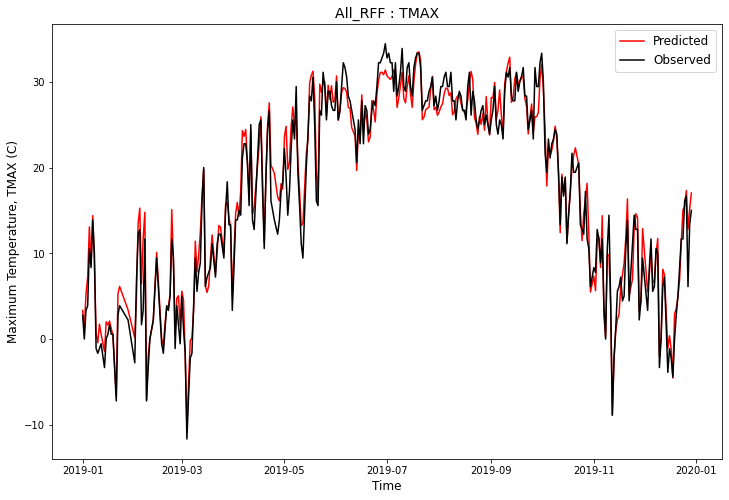

In [0]:
plt.figure(figsize=(12,8))
plt.plot(all_data_daily_val.index, predictions_TMAX, '-r',label='Predicted')
plt.plot(all_data_daily_val.index, val_Target_TMAX, '-k',label='Observed')
plt.title('All_RFF : TMAX',fontsize=14)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Maximum Temperature, TMAX (C)',fontsize=12)
plt.legend(fontsize=12)
plt.show()

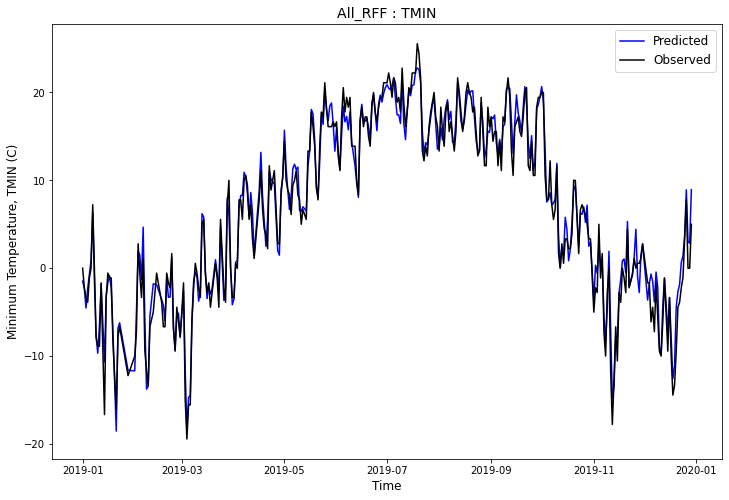

In [0]:
plt.figure(figsize=(12,8))
plt.plot(all_data_daily_val.index, predictions_TMIN, '-b',label='Predicted')
plt.plot(all_data_daily_val.index, val_Target_TMIN, '-k',label='Observed')
plt.title('All_RFF : TMIN',fontsize=14)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Minimum Temperature, TMIN (C)',fontsize=12)
plt.legend(fontsize=12)
plt.show()

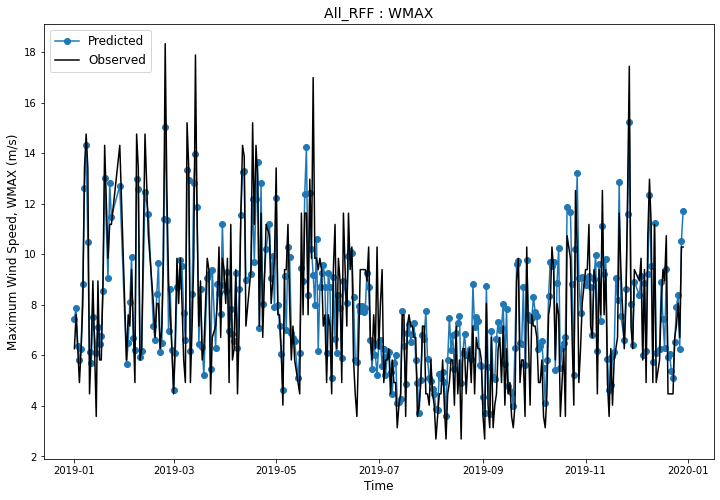

In [0]:
plt.figure(figsize=(12,8))
plt.plot(all_data_daily_val.index, predictions_WMAX, '-o',label='Predicted')
plt.plot(all_data_daily_val.index, val_Target_WMAX, '-k',label='Observed')
plt.title('All_RFF : WMAX',fontsize=14)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Maximum Wind Speed, WMAX (m/s)',fontsize=12)
plt.legend(fontsize=12)
plt.show()

# **Investigation of Feature/Predictor Importances**

Next, the relative importances of the features/predictors are investigated to study which are the most effective predictors to improve the accuracy of the forecast mdoel.

Variable: TMAXGFS              Importance: 0.97
Variable: TMINGFS              Importance: 0.0
Variable: WMAXGFS              Importance: 0.0
Variable: RTOTGFS              Importance: 0.0
Variable: year                 Importance: 0.0
Variable: month                Importance: 0.0
Variable: day                  Importance: 0.0
Variable: DWPC                 Importance: 0.0
Variable: HCLD                 Importance: 0.0
Variable: LCLD                 Importance: 0.0
Variable: MCLD                 Importance: 0.0
Variable: PRCP                 Importance: 0.0
Variable: PRES                 Importance: 0.0
Variable: TMPC                 Importance: 0.0
Variable: UWND                 Importance: 0.0
Variable: VWND                 Importance: 0.0
Variable: WSPD                 Importance: 0.0
Variable: DWPC925              Importance: 0.0
Variable: DWPC850              Importance: 0.0
Variable: DWPC700              Importance: 0.0
Variable: DWPC500              Importance: 0.0
Variable: DW

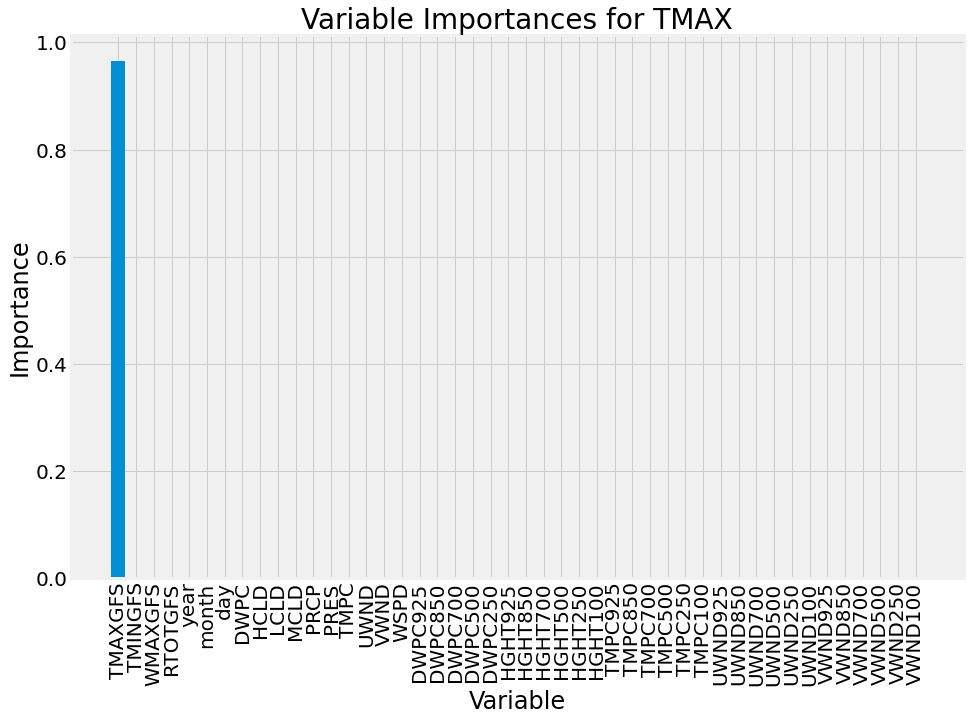

In [0]:
# Get numerical feature importances
# TMAX

importances_TMAX = list(rf_TMAX.feature_importances_)
# List of tuples with variable and importance
feature_importances_TMAX = [(feature, round(importance, 2)) for feature, importance in zip(train_feature_list, importances_TMAX)]
# Sort the feature importances by most important first
feature_importances_TMAX = sorted(feature_importances_TMAX, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_TMAX];

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,10))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances_TMAX)))
# Make a bar chart
plt.bar(x_values, importances_TMAX, orientation = 'vertical')
# Tick labels for x axis
plt.yticks(fontsize=20)
plt.xticks(x_values, train_feature_list, rotation='vertical',fontsize=20)
# Axis labels and title
plt.ylabel('Importance',fontsize=24); plt.xlabel('Variable',fontsize=24); plt.title('Variable Importances for TMAX',fontsize=28);
plt.show()

Variable: TMINGFS              Importance: 0.94
Variable: TMPC                 Importance: 0.02
Variable: DWPC                 Importance: 0.01
Variable: TMAXGFS              Importance: 0.0
Variable: WMAXGFS              Importance: 0.0
Variable: RTOTGFS              Importance: 0.0
Variable: year                 Importance: 0.0
Variable: month                Importance: 0.0
Variable: day                  Importance: 0.0
Variable: HCLD                 Importance: 0.0
Variable: LCLD                 Importance: 0.0
Variable: MCLD                 Importance: 0.0
Variable: PRCP                 Importance: 0.0
Variable: PRES                 Importance: 0.0
Variable: UWND                 Importance: 0.0
Variable: VWND                 Importance: 0.0
Variable: WSPD                 Importance: 0.0
Variable: DWPC925              Importance: 0.0
Variable: DWPC850              Importance: 0.0
Variable: DWPC700              Importance: 0.0
Variable: DWPC500              Importance: 0.0
Variable: 

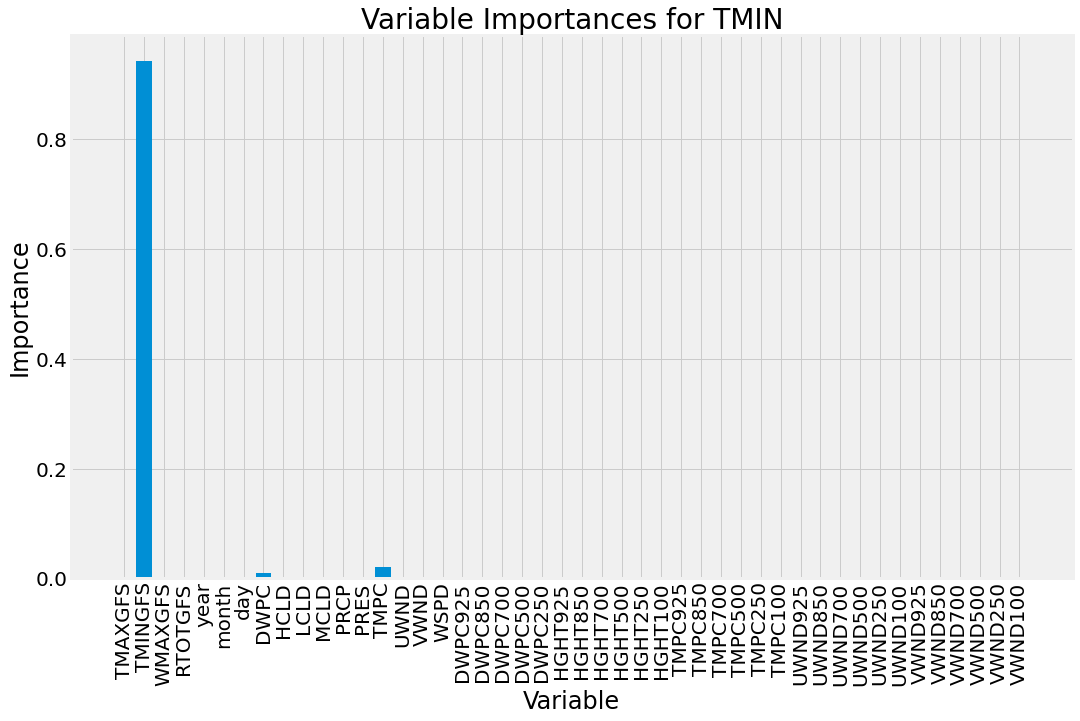

In [0]:
# Get numerical feature importances
# TMIN

importances_TMIN = list(rf_TMIN.feature_importances_)
# List of tuples with variable and importance
feature_importances_TMIN = [(feature, round(importance, 2)) for feature, importance in zip(train_feature_list, importances_TMIN)]
# Sort the feature importances by most important first
feature_importances_TMIN = sorted(feature_importances_TMIN, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_TMIN];

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,10))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances_TMIN)))
# Make a bar chart
plt.bar(x_values, importances_TMIN, orientation = 'vertical')
# Tick labels for x axis
plt.yticks(fontsize=20)
plt.xticks(x_values, train_feature_list, rotation='vertical',fontsize=20)
# Axis labels and title
plt.ylabel('Importance',fontsize=24); plt.xlabel('Variable',fontsize=24); plt.title('Variable Importances for TMIN',fontsize=28);
plt.show()

Variable: WMAXGFS              Importance: 0.68
Variable: year                 Importance: 0.02
Variable: day                  Importance: 0.02
Variable: HGHT100              Importance: 0.02
Variable: TMAXGFS              Importance: 0.01
Variable: RTOTGFS              Importance: 0.01
Variable: HCLD                 Importance: 0.01
Variable: LCLD                 Importance: 0.01
Variable: MCLD                 Importance: 0.01
Variable: PRCP                 Importance: 0.01
Variable: PRES                 Importance: 0.01
Variable: UWND                 Importance: 0.01
Variable: VWND                 Importance: 0.01
Variable: WSPD                 Importance: 0.01
Variable: DWPC700              Importance: 0.01
Variable: DWPC500              Importance: 0.01
Variable: DWPC250              Importance: 0.01
Variable: HGHT925              Importance: 0.01
Variable: TMPC250              Importance: 0.01
Variable: TMPC100              Importance: 0.01
Variable: UWND925              Importanc

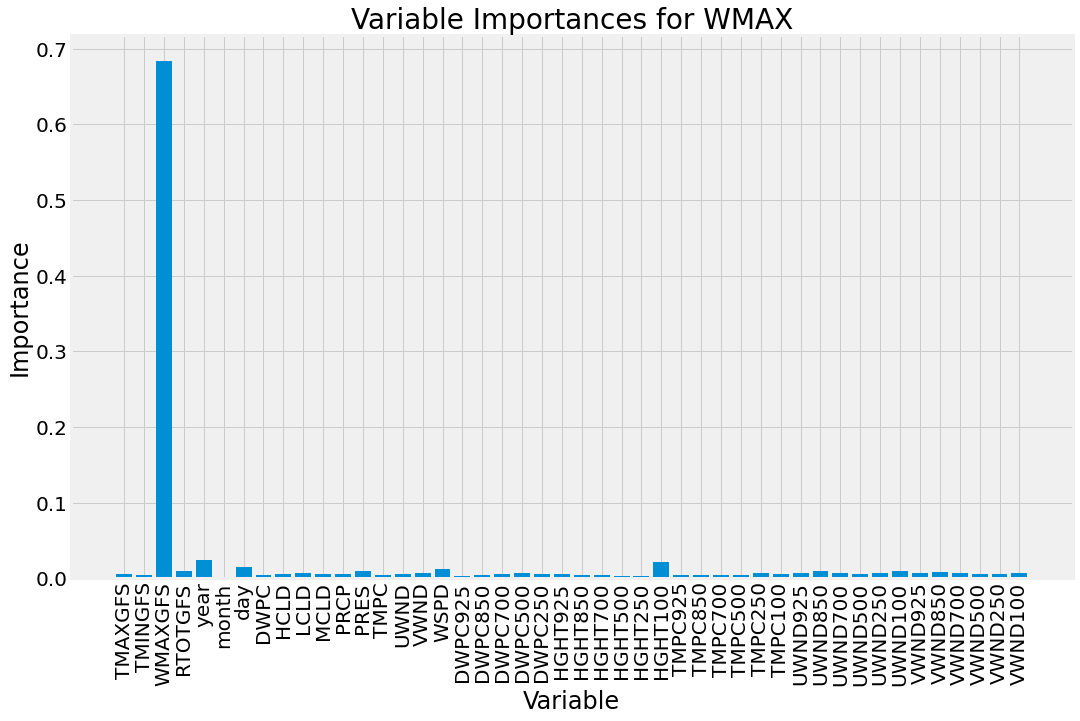

In [0]:
# Get numerical feature importances
# WMAX

importances_WMAX = list(rf_WMAX.feature_importances_)
# List of tuples with variable and importance
feature_importances_WMAX = [(feature, round(importance, 2)) for feature, importance in zip(train_feature_list, importances_WMAX)]
# Sort the feature importances by most important first
feature_importances_WMAX = sorted(feature_importances_WMAX, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_WMAX];

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,10))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances_WMAX)))
# Make a bar chart
plt.bar(x_values, importances_WMAX, orientation = 'vertical')
# Tick labels for x axis
plt.yticks(fontsize=20)
plt.xticks(x_values, train_feature_list, rotation='vertical',fontsize=20)
# Axis labels and title
plt.ylabel('Importance',fontsize=24); plt.xlabel('Variable',fontsize=24); plt.title('Variable Importances for WMAX',fontsize=28);
plt.show()

# **Now, with the goal to improve the model predictions, the "most important" feature is selected to make the prediction.** 

In [0]:
# New random forest with only the two most important variables
rf_most_important_TMAX = RandomForestRegressor(n_estimators=1000,  random_state=42, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                      max_features='auto', max_leaf_nodes=None, bootstrap=True)

# Extract the most important features
important_indices_TMAX = [train_feature_list.index('TMAXGFS')]
train_important_TMAX = all_data_daily_train_feature[:, important_indices_TMAX]
test_important_TMAX = all_data_daily_val_feature[:, important_indices_TMAX]

# Train the random forest
rf_most_important_TMAX.fit(train_important_TMAX, train_Target_TMAX)

# Make predictions and determine the error
predictions_most_important_TMAX = rf_most_important_TMAX.predict(test_important_TMAX)
errorsmost_important_TMAX = abs(predictions_most_important_TMAX - val_Target_TMAX)

# Evaluating the Algorithm
from sklearn import metrics
print('TMAX Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(val_Target_TMAX,predictions_most_important_TMAX)))





TMAX Root Mean Squared Error: 2.2456717226040777


# **Lo and behold!**

The RMSE shows that including the most important feature doesn't necessarily improve the quality of forecast in this case. Detailed error statistics for all the variables are listed in the presentation.



# **Next, we need to build the Precipitation Prediction Random Forest Regression Model.**

Similarly as before, to begin with the final step of preserving data quality, the GFS Dewpoint at 100hPA data are disregarded due to poor data quality. 

In [0]:
#Drop the 'DWPC100' column as most of it is bad/unreliable data
all_data_daily_pcp = all_data.drop(columns = ['DWPC100'])

#Drop the row if any column has NaN
all_data_daily_pcp = all_data_daily_pcp.dropna(axis=0)

# Set 'Timestep' column as index
all_data_daily_pcp = all_data_daily_pcp.set_index(pd.to_datetime(all_data_daily_pcp['Timestamp'])).drop(columns = 'Timestamp')

# Manually splitting all the data into 'Training' and 'Validation' Datasets

# Get data from 2010 to 2018 to use for training
all_data_daily_pcp_train = all_data_daily_pcp['2010-01-01':'2018-12-31']

# Get data for 2019 to use for validation
all_data_daily_pcp_val  = all_data_daily_pcp['2019-01-01':'2019-12-30']


# Targets are the values we want to predict
train_Target_RTOT = np.array(all_data_daily_pcp_train['RTOTOBS'])
val_Target_RTOT = np.array(all_data_daily_pcp_val['RTOTOBS'])

# Remove the targets from the main dataframe
all_data_daily_pcp_train_feature = all_data_daily_pcp_train.drop(columns=['TMAXOBS','TMINOBS','WMAXOBS','RTOTOBS'])
all_data_daily_pcp_val_feature = all_data_daily_pcp_val.drop(columns=['TMAXOBS','TMINOBS','WMAXOBS','RTOTOBS'])

# Saving feature names for later use
train_feature_list = list(all_data_daily_pcp_train_feature.columns)
val_feature_list = list(all_data_daily_pcp_val_feature.columns)

# Convert to numpy array
all_data_daily_pcp_train_feature = np.array(all_data_daily_pcp_train_feature)
all_data_daily_pcp_val_feature = np.array(all_data_daily_pcp_val_feature)





In [0]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# The n_estimators parameter defines the number of trees in the random forest. 
# You can use any numeric value to the n_estimators parameter. 
# However, start with a low value is recommended.
# The random_state parameter is the seed used by the random number. 
# Passing any value (whether a specific int, e.g., 0, or a RandomState instance),will not change that. 
# The only rationale for passing in an int value (0 or otherwise) is to 
# make the outcome consistent across calls: 
# if you call this with random_state=0 (or any other value), 
# then each and every time, you’ll get the same result generator.

# Instantiate model for RTOT
rf_RTOT = RandomForestRegressor(n_estimators=1000,  random_state=42, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                      max_features='auto', max_leaf_nodes=None, bootstrap=True)

# Train the model on training data
rf_RTOT.fit(all_data_daily_pcp_train_feature, train_Target_RTOT);

# Use the forest's predict method on the test data
predictions_RTOT = rf_RTOT.predict(all_data_daily_pcp_val_feature)

# Calculate the absolute errors
errors_RTOT = abs(predictions_RTOT - val_Target_RTOT)

# Evaluating the Algorithm
from sklearn import metrics

print('RTOT Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(val_Target_RTOT,predictions_RTOT)))








RTOT Root Mean Squared Error: 1.5064464911177873


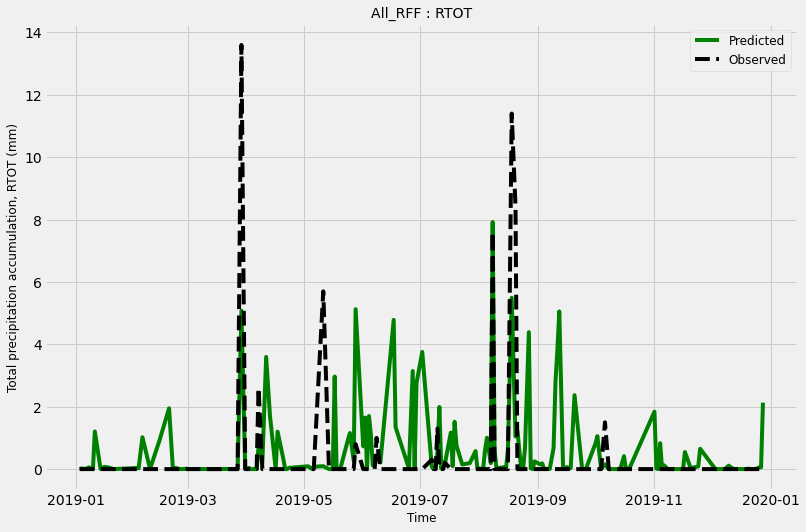

In [0]:
plt.figure(figsize=(12,8))
plt.plot(all_data_daily_pcp_val.index, predictions_RTOT, '-g',label='Predicted')
plt.plot(all_data_daily_pcp_val.index, val_Target_RTOT, '--k',label='Observed')
plt.title('All_RFF : RTOT',fontsize=14)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Total precipitation accumulation, RTOT (mm)',fontsize=12)
plt.legend(fontsize=12)
plt.show()

Variable: RTOTGFS              Importance: 0.16
Variable: PRCP                 Importance: 0.11
Variable: DWPC500              Importance: 0.06
Variable: HGHT250              Importance: 0.04
Variable: WMAXGFS              Importance: 0.03
Variable: LCLD                 Importance: 0.03
Variable: DWPC850              Importance: 0.03
Variable: DWPC250              Importance: 0.03
Variable: HGHT700              Importance: 0.03
Variable: TMPC250              Importance: 0.03
Variable: TMPC100              Importance: 0.03
Variable: day                  Importance: 0.02
Variable: MCLD                 Importance: 0.02
Variable: PRES                 Importance: 0.02
Variable: UWND                 Importance: 0.02
Variable: DWPC700              Importance: 0.02
Variable: HGHT500              Importance: 0.02
Variable: HGHT100              Importance: 0.02
Variable: UWND700              Importance: 0.02
Variable: VWND500              Importance: 0.02
Variable: VWND250              Importanc

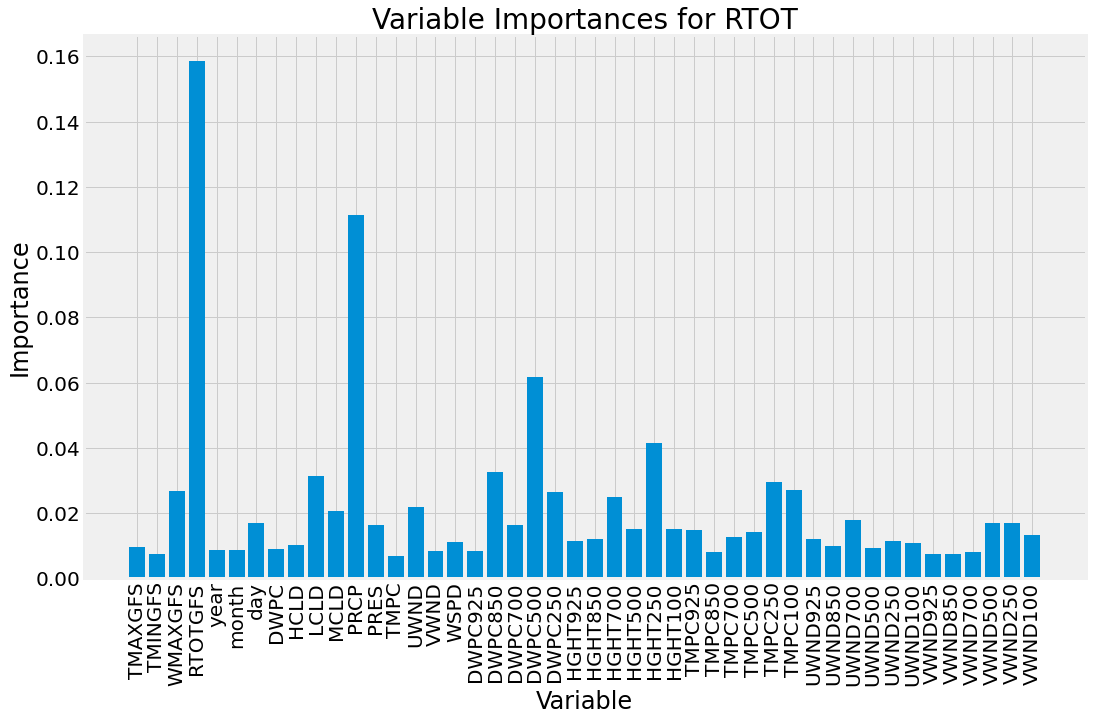

In [0]:
# Get numerical feature importances
# RTOT

importances_RTOT = list(rf_RTOT.feature_importances_)
# List of tuples with variable and importance
feature_importances_RTOT = [(feature, round(importance, 2)) for feature, importance in zip(train_feature_list, importances_RTOT)]
# Sort the feature importances by most important first
feature_importances_RTOT = sorted(feature_importances_RTOT, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_RTOT];

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,10))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances_RTOT)))
# Make a bar chart
plt.bar(x_values, importances_RTOT, orientation = 'vertical')
# Tick labels for x axis
plt.yticks(fontsize=20)
plt.xticks(x_values, train_feature_list, rotation='vertical',fontsize=20)
# Axis labels and title
plt.ylabel('Importance',fontsize=24); plt.xlabel('Variable',fontsize=24); plt.title('Variable Importances for RTOT',fontsize=28);
plt.show()

# **For Precipitation,** overall there is weak dependence on the features but still, the three features that stand out are : RTOTGFS (GFS forecast for precip), precip at the PRCP(surface), DWPC500 (Dewpoint Temperature at 500 hPa).

In [0]:
# New random forest with only the two most important variables
rf_most_important_RTOT = RandomForestRegressor(n_estimators=1000,  random_state=42, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                      max_features='auto', max_leaf_nodes=None, bootstrap=True
                      )
# Extract the two most important features
important_indices_RTOT = [train_feature_list.index('RTOTGFS'),train_feature_list.index('PRCP')]
train_important_RTOT = all_data_daily_pcp_train_feature[:, important_indices_RTOT]
test_important_RTOT = all_data_daily_pcp_val_feature[:, important_indices_RTOT]

# Train the random forest
rf_most_important_RTOT.fit(train_important_RTOT, train_Target_RTOT)

# Make predictions and determine the error
predictions_most_important_RTOT = rf_most_important_RTOT.predict(test_important_RTOT)
errorsmost_important_RTOT = abs(predictions_most_important_RTOT - val_Target_RTOT)

# Evaluating the Algorithm
from sklearn import metrics
print('RTOT Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(val_Target_RTOT,predictions_most_important_RTOT)))






RTOT Root Mean Squared Error: 2.0943826608166174


# Again, we see that the prediction of precipitation doesn't improve with just including two "most important" features in training the model. 

# **Key takeaways from the results from this Random Forest Regression Model**

* For the Random Forest Regression (RFR) Model for this case, the predictions improved after increasing the number of decision trees (n_estimators) from n=10 to 100, but not from 100 to 1000 for the “simple” runs in the model. (Results shown in the presentation).

* The most important predictors were usually the respective GFS forecast variables - TMAXGFS, TMINGFS, WMAXGFS and RTOTGFS.

* For RFR model - adding more predictors (All_model) seemed to yield the best result

* Choosing the “most important” feature(s) didn’t improve the quality of the predictions.

# **Overall the best RMSE scores for the four variables from the RFR model are:**

* TMAX - 1.93 deg C
* TMIN - 1.60 deg C
* WMAX - 1.46 m/s
* RTOT - 1.50 mm 
